# Classification with MNIST data

Widely studied dataset consisting of 70,000 handwritten numbers ranging 0,1...9.  Each image has 284 features (28x28) pixels with pixel intensity ranging from 0 to 255.

## Importing and examining data

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore',category=FutureWarning)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X = mnist["data"]
y = mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

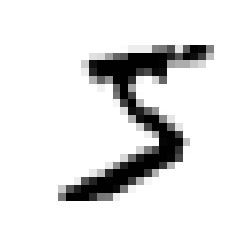

5

In [17]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary", interpolation="nearest")
plt.axis("off")
plt.show()
y[0]

In [11]:
# My girlfriend and I did move to her hometown in Portland after I graduated. 
y = y.astype(np.uint8)

In [18]:
#Data is already pre-shuffled, so we can easily make train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Is the digit a 5?  Making a binary classifier

In [19]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Starting with a Stochastic Gradient Descent (SGD) classifier

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) #ensuring repeatability by seeding random generator
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
# Does the SGD Classifier correctly predict the 5 we have above?
sgd_clf.predict([some_digit])

array([False])

In [26]:
# That was a difficult digit... let's see how good it really is
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

Have about 95% accuracy! But let's see how compares to a classifier that just puts every digit in the "not 5" category

In [28]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Of course we get about 90% accuracy considering the 5 digit shows up only about one in 10 times...

### Evaluating our SGDClassifier

In [30]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_sgd = precision_score(y_train_5, y_train_pred)
recall_sgd = recall_score(y_train_5, y_train_pred)
f1_sgd = f1_score(y_train_5, y_train_pred)
print("Precision: ", precision_sgd)
print("Recall: ", recall_sgd)
print("f1 Score: ", f1_sgd)

Precision:  0.7325581395348837
Recall:  0.8018815716657444
f1 Score:  0.765653896961691


The SGDClassifier got it right 73% of the time when predicting a 5, and only correctly predicted 80% of the total 5's. f1_score is harmonic mean of precision and recall (Penalizes small numbers more than simple average). Better metrics to look at than accuracy considering 5 and not_5 are not equally represented.

#### Let's take a closer look at how precision and recall are correlated

Changing the decision threshold impacts precision/recall.

In [34]:
# Want the decision function scores for predicted values so we can manually change the decision threshold ourselves
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc ="center left")
    plt.ylim([0,1.05])

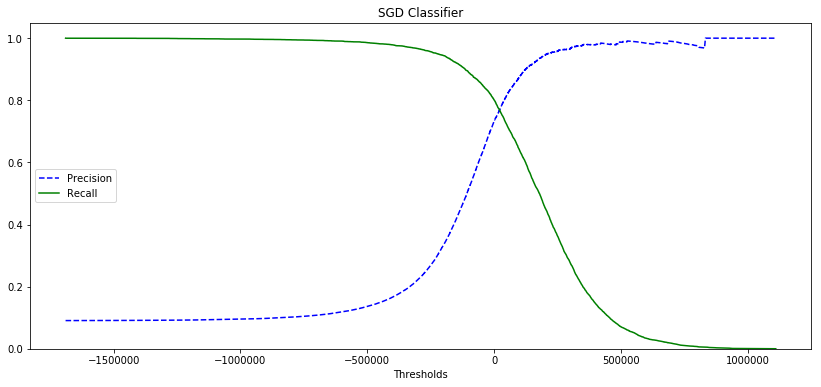

In [49]:
plt.figure(figsize=(14,6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("SGD Classifier")
plt.show()

In [45]:
def plot_precision_vs_recall(precisions, recalls, label=None):
    plt.plot(recalls[:-1], precisions[:-1], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0,1.05])

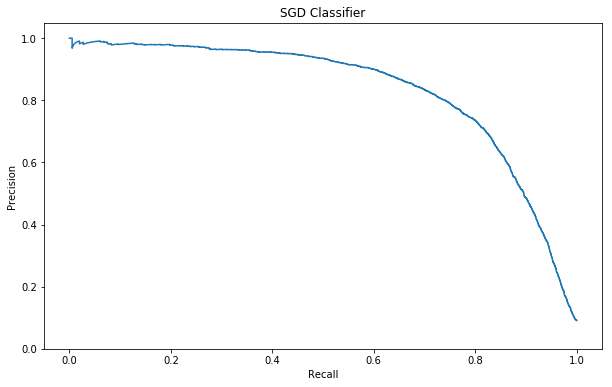

In [48]:
plt.figure(figsize=(10,6))
plot_precision_vs_recall(precisions,recalls)
plt.title("SGD Classifier")
plt.show()

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
sgd_auc = roc_auc_score(y_train_5, y_scores)

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

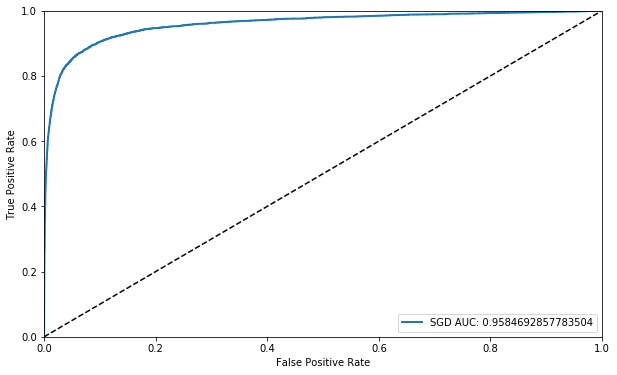

In [60]:
plt.figure(figsize=(10,6))
sgd_label = "SGD AUC: " + str(sgd_auc)
plot_roc_curve(fpr, tpr, sgd_label)
plt.legend(loc = "lower right")
plt.show()

### Let's compare an SGD Classifier to a Random Forest Classifier (still only 5 or not 5)

In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")

In [63]:
# will use the positive class's probabilites as the scores for the ROC curve
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
forest_auc = roc_auc_score(y_train_5,y_scores_forest)

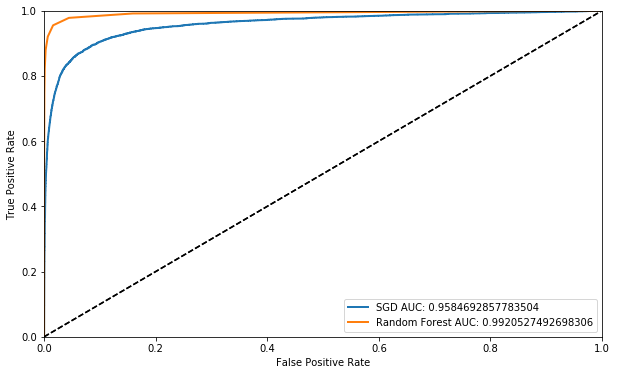

In [65]:
plt.figure(figsize=(10,6))

sgd_label = "SGD AUC: " + str(sgd_auc)
plot_roc_curve(fpr, tpr, sgd_label)

forest_label = "Random Forest AUC: " + str(forest_auc)
plot_roc_curve(fpr_forest, tpr_forest, forest_label)

plt.legend(loc = "lower right")
plt.show()

In [68]:
y_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

precision_forest = precision_score(y_train_5, y_predict_forest)
recall_forest = recall_score(y_train_5, y_predict_forest)
f1_forest = f1_score(y_train_5, y_predict_forest)
print("Precision: ", precision_forest)
print("Recall: ", recall_forest)
print("f1 Score: ", f1_forest)

Precision:  0.986046511627907
Recall:  0.8212506917542889
f1 Score:  0.8961352657004831


#### Random forest did better than SGD in every respect when compared to the SGD Classifier

## Multiclass Classification

#### Random Forest has capability to construct probabilities directly

In [74]:
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

We see that the random forest suggests the digit is a 5 with 80% probability and a 3 with 20% probability

#### But SGD can only do binary classification
 Since SGD does not have the ability to handle multiple classes directly, it actually produces a One-versus-all classifier for each different class under the hood:

In [69]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [70]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-433195.51807197, -338154.39320296, -233775.78280018,
         -96549.33208399, -775699.13613034,  -45148.19955869,
        -536304.97603686, -298210.05377635, -535633.57179217,
        -490653.60782097]])

We see 10 different scores (due to the 10 different one-versus-all classifiers), one for each digit, and the largest score is indeed a 5 followed by a 3 -- what we would expect after looking at the digit above.

Now let's make a One-vs-One classifier with the SGD Classifier

In [71]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [72]:
len(ovo_clf.estimators_)

45

We see that the classifier still gets the right answer, but it had to train N(N-1)/2 classifier to do so with the One-vs-One approach for a total of 45 different SGD classifiers

#### Taking a closer look at SGD multiclassification performance

In [75]:
cross_val_score(sgd_clf,X_train, y_train, cv=3, scoring="accuracy")

array([0.86872625, 0.87639382, 0.87848177])

Get about 87% accuracy using the SGD classifier! Much better than the 10% we would get with a purely random classifier.

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [77]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90736853, 0.90884544, 0.91363705])

Just scaling the training data by it's standard deviation increased the accuracy from 87% to 90%!

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

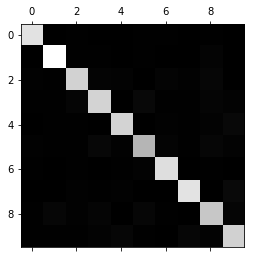

In [84]:
plt.matshow(conf_mx,cmap="gray")

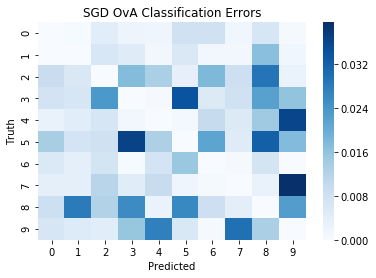

In [98]:
# Normalizing the confusion matrix by the number of images in each class and subtracting the diagonal to see the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx,0)
sns.heatmap(norm_conf_mx, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("SGD OvA Classification Errors")
plt.show()

Most common erros include:
    * Confusing 3 as 5 and 5 as 3
    * Confusing 9 as 7 or 4
    * Confusing 8 as 5

Let's look at some common examples of what the classifier got right and wrong:

In [103]:
def plot_digits(data, images_per_row=5):
    size = 28
    images = [image.reshape(size,size) for image in data]
    n_rows = (len(data) - 1)// images_per_row + 1
    n_empty = n_rows * images_per_row - len(data)
    images.append(np.zeros((size, size * n_empty)))
    
    row_images = []
    for row in range(images_per_row):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages,axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,cmap="binary")
    plt.axis("off")

Text(0.5, 1.0, 'Predicted: 9 Actual: 9')

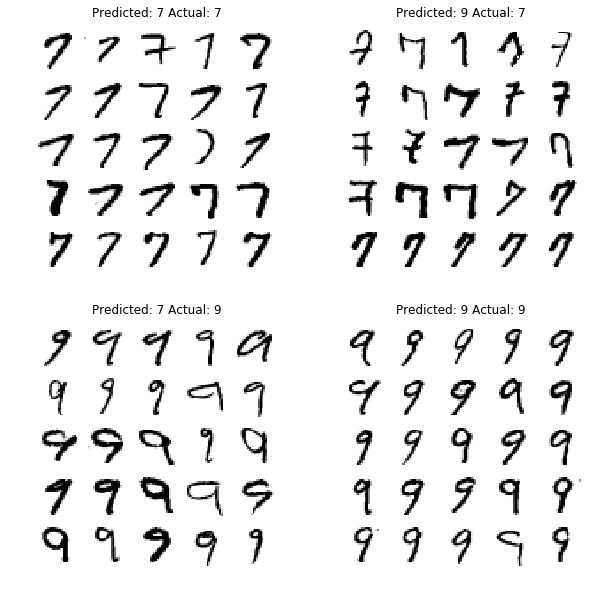

In [115]:
dig_a, dig_b = 7, 9
X_aa = X_train[(y_train==dig_a) & (y_train_pred==dig_a)]
X_ab = X_train[(y_train==dig_a) & (y_train_pred==dig_b)]
X_ba = X_train[(y_train==dig_b) & (y_train_pred==dig_a)]
X_bb = X_train[(y_train==dig_b) & (y_train_pred==dig_b)]


plt.figure(figsize=(10,10))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5);plt.title("Predicted: " + str(dig_a) + " Actual: " + str(dig_a))
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5);plt.title("Predicted: " + str(dig_b) + " Actual: " + str(dig_a))
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5);plt.title("Predicted: " + str(dig_a) + " Actual: " + str(dig_b))
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5);plt.title("Predicted: " + str(dig_b) + " Actual: " + str(dig_b))

## Multilabel Classification

#### Making two synthetic labels:
1. large number ( >= 7)
2. odd number

In [116]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [119]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [120]:
knn_clf.predict([some_digit])

array([[False,  True]])

The KNN classifier correctly predicts that the 5 digit was not large and was odd

## KNN Classification

Can we achieve greater than 97% accuracy on the test set using the KNeighborsClassifier?

#### First, let's perform some feature engineering

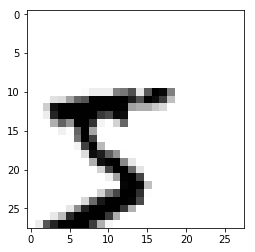

In [138]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    return shift(image.reshape(28,28), [dx, dy], cval=0).reshape(784)

shifted_image = shift_image(some_digit,5,-5)
plt.imshow(shifted_image.reshape(28,28), cmap="binary")

#### Adding shifted images to the training set

In [140]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx,dy in ((1,0), (-1,0), (0,1), (0,-1)):
    shifted_images = np.apply_along_axis(shift_image, axis=1, arr=X_train,dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)

In [141]:
%time knn_clf.fit(X_train_expanded, y_train_expanded)

CPU times: user 3min 32s, sys: 3.92 s, total: 3min 36s
Wall time: 3min 41s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [142]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_expanded_pred)

0.9754